# Hubble Source Catalog API Notebook

A [new MAST interface][1] supports queries to the current and previous versions of the [Hubble Source Catalog][2]. It allows searches of the summary table (with multi-filter mean photometry) and the detailed table (with all the multi-epoch measurements).  It also has an associated [API][3], which is used in this notebook.

This is based on [HSC Use Case #3][4].
* It searches the HSC for variable objects in the vicinity of dwarf galaxy IC 1613,
* shows the positions of those objects in a color-magnitude diagram,
* extracts light curves for an example object, and
* displays cutout images from the Hubble observations that were used for the light curve measurements.

The whole process takes only 30 seconds to complete.

Another [notebook][5] generates a color-magnitude diagram for the Small Magellanic Cloud in only a couple of minutes.  A more complex notebook that shows how to access the proper motion tables using the HSC API is also [available][6].


  [1]: https://catalogs.mast.stsci.edu/hsc
  [2]: https://archive.stsci.edu/hst/hsc
  [3]: https://catalogs.mast.stsci.edu/docs/hsc.html
  [4]: https://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html
  [5]: ../HSCV3_SMC_API/hscv3_smc_api.ipynb
  [6]: ../SWEEPS_HSCV3P1_API/sweeps_hscv3p1_api.ipynb

# Instructions: 
* Complete the initialization steps [described below](#Initialization).
* Run the notebook.

Running the notebook from top to bottom takes about 30 seconds.


# Table of Contents
* [Initialization](#Initialization)
* [Get metadata on available HSC columns](#metadata)
* [Find variable objects in IC 1613](#ic1613)
    * [Use MAST name resolver](#resolver)
    * [Search HSC summary table](#summary)
    * [Plot variability index versus magnitude](#variability)
    * [Show variable objects in a color-magnitude diagram](#cmd)
* [Get HSC light curve for a variable](#lightcurve)
* [Extract HLA cutout images for the variable](#cutouts)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

1. _This notebook requires the use of **Python 3**._
1. Modules can be installed with `conda`, if using the [Anaconda distribution][1] of python, or with `pip`.
   - If you are using `conda`, do not install / update / remove a module with `pip`, that exists in a `conda` [channel][2].
   - If a module is not available with `conda`, then it's okay to install it with `pip`


  [1]: https://www.anaconda.com/products/distribution
  [2]: https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/channels.html

In [1]:
import astropy
from astropy.coordinates import SkyCoord
import time
import requests
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint

from astropy.table import Table
import pandas as pd

from PIL import Image
from io import BytesIO, StringIO

# set width for pprint
astropy.conf.max_width = 150

In [2]:
# set universal matplotlib parameters
plt.rcParams.update({'font.size': 16})

### MAST API functions

- Execute HSC searches and resolve names using [MAST query][1].
- Here we define several interrelated functions for retrieving information from the MAST API.
  - The `hcvcone(ra, dec, radius [, keywords])` function searches the HCV catalog near a position.
  - The `hcvsearch()` function performs general non-positional queries.
  - The `hcvmetadata()` function gives information about the columns available in a table. 
  
  
  [1]: https://mast.stsci.edu/api/v0/MastApiTutorial.html

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"


def hsccone(ra, dec, radius, table="summary", release="v3", format="csv", magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a cone search of the HSC catalog

    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """

    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hscsearch(table=table, release=release, format=format, magtype=magtype,
                     columns=columns, baseurl=baseurl, verbose=verbose, **data)


def hscsearch(table="summary", release="v3", magtype="magaper2", format="csv",
              columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)

    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json, table
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """

    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv", "votable", "json", 'table'):
        raise ValueError("Bad value for format")
    if format == "table":
        rformat = "csv"
    else:
        rformat = format
    url = f"{cat2url(table, release, magtype, baseurl=baseurl)}.{rformat}"
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hscmetadata(table, release, magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError(f"Some columns not found in table: {', '.join(badcols)}")
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = f"[{','.join(columns)}]"

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    elif format == "table":
        # use pandas to work around bug in Windows for ascii.read
        return Table.from_pandas(pd.read_csv(StringIO(r.text)))
    else:
        return r.text


def hscmetadata(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = f"{cat2url(table, release, magtype, baseurl=baseurl)}/metadata"
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'], x['type'], x['description']) for x in v],
                names=('name', 'type', 'description'))
    return tab


def cat2url(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table, release, magtype)
    if table == "summary":
        url = f"{baseurl}/{release}/{table}/{magtype}"
    else:
        url = f"{baseurl}/{release}/{table}"
    return url


def checklegal(table, release, magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError(f"Bad value for release (must be one of {', '.join(releaselist)})")
    if release == "v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions")
    if table not in tablelist:
        raise ValueError(f"Bad value for table (for {release} must be one of {', '.join(tablelist)})")
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError(f"Bad value for magtype (must be one of {', '.join(magtypelist)})")

## Get metadata on available columns <a name="metadata"></a>

The `metadata` query returns information on the columns in the table.  It works for any of the tables in the API (`summary`, `detailed`, `propermotions`, `sourcepositions`).

Note that the summary table has a huge number of columns!  Each of the 133 filter/detector combinations has 3 columns with the magnitude, median absolute deviation (MAD, a robust measure of the scatter among the measurements), and the number of independent measurements in the filter.  The filter name includes a prefix for the detector (`A`=ACS/WFC, `W3`=WFC3/UVIS or WFC3/IR, `W2`=WFPC2) followed by the standard name of the filter.  So for instance all three instruments have an F814W filter, so there are columns for `A_F814W`, `W3_F814W`, and `W2_F814W`.

In [4]:
meta = hscmetadata("summary")
print(len(meta), "columns in summary")
filterlist = meta['name'][19::3].tolist()
print(len(filterlist), "filters")
pprint(filterlist, compact=True)
meta[:19]

418 columns in summary
133 filters
['W3_BLANK', 'W2_F122M', 'W2_F160BN15', 'W2_F160BW', 'W2_F170W', 'W2_F185W',
 'W3_F200LP', 'W3_F218W', 'W2_F218W', 'W3_F225W', 'W3_FQ232N', 'W3_FQ243N',
 'W2_F255W', 'W3_F275W', 'W3_F280N', 'W3_G280', 'W2_F300W', 'W3_F300X',
 'W3_F336W', 'W2_F336W', 'W3_F343N', 'W2_F343N', 'W3_F350LP', 'W3_F373N',
 'W2_F375N', 'W3_FQ378N', 'W2_F380W', 'W3_FQ387N', 'W3_F390M', 'W2_F390N',
 'W3_F390W', 'W3_F395N', 'W3_F410M', 'W2_F410M', 'W3_FQ422M', 'A_F435W',
 'W3_FQ436N', 'W3_FQ437N', 'W2_F437N', 'W3_F438W', 'W2_F439W', 'W2_F450W',
 'W3_F467M', 'W2_F467M', 'W3_F469N', 'W2_F469N', 'A_F475W', 'W3_F475W',
 'W3_F475X', 'W3_F487N', 'W2_F487N', 'W3_FQ492N', 'A_F502N', 'W3_F502N',
 'W2_F502N', 'W3_FQ508N', 'W3_F547M', 'W2_F547M', 'A_F550M', 'A_F555W',
 'W3_F555W', 'W2_F555W', 'W2_F569W', 'W3_FQ575N', 'W2_F588N', 'W3_F600LP',
 'A_F606W', 'W3_F606W', 'W2_F606W', 'W3_FQ619N', 'W3_F621M', 'W2_F622W',
 'A_F625W', 'W3_F625W', 'W3_F631N', 'W2_F631N', 'W3_FQ634N', 'W3_F645N',
 'W3_

name,type,description
str16,str5,str163
MatchID,long,identifier for the match
MatchRA,float,right ascension coordinate of the match position
MatchDec,float,declination coordinate of the match position
DSigma,float,standard deviation of source positions in match
AbsCorr,char,indicator of whether the match contains sources that are aligned to a standard catalog
NumFilters,int,number of filters in match with sources detected in the aper2 aperture
NumVisits,int,number of visits in match with sources detected in the aper2 aperture
NumImages,int,"number of Hubble Legacy Archive single filter, visit-combined (level 2) images in match with sources detected in the aper2 aperture"
StartTime,char,earliest start time of exposures in match with sources detected in the aper2 aperture


## Find variable objects in the dwarf irregular galaxy IC 1613 <a name="ic1613"></a>

This is based on [HSC Use Case #3](https://archive.stsci.edu/hst/hsc/help/use_case_3_v2.html), which shows an example of selecting objects from the HSC in portal.  This is simple to do using the HSC API.

### Use `astropy` name resolver to get position of IC 1613 <a name="resolver"></a>

In [5]:
target = 'IC 1613'
coord_ic1613 = SkyCoord.from_name(target)

ra_ic1613 = coord_ic1613.ra.degree
dec_ic1613 = coord_ic1613.dec.degree
print(f'ra: {ra_ic1613}\ndec: {dec_ic1613}')

ra: 16.2016962
dec: 2.1194959


### Select objects with enough measurements to determine variability <a name="summary"></a>

This searches the summary table for objects within 0.5 degrees of the galaxy center that have at least 10 measurements in both ACS F475W and F814W.

In [6]:
# save typing a quoted list of columns
columns = """MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,
    A_F475W, A_F475W_N, A_F475W_MAD,
    A_F814W, A_F814W_N, A_F814W_MAD""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints = {'A_F475W_N.gte': 10, 'A_F814W_N.gte': 10}

t0 = time.time()
tab = hsccone(ra_ic1613, dec_ic1613, 0.5, table="summary", release='v3', columns=columns, verbose=True, format="table", **constraints)
print(f"{(time.time()-t0):.1f} s: retrieved data and converted to {len(tab)}-row astropy table")

# clean up the output format
tab['A_F475W'].format = "{:.3f}"
tab['A_F475W_MAD'].format = "{:.3f}"
tab['A_F814W'].format = "{:.3f}"
tab['A_F814W_MAD'].format = "{:.3f}"
tab['MatchRA'].format = "{:.6f}"
tab['MatchDec'].format = "{:.6f}"
tab['StartMJD'].format = "{:.5f}"
tab['StopMJD'].format = "{:.5f}"
tab

https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/summary/magaper2.csv?A_F475W_N.gte=10&A_F814W_N.gte=10&ra=16.2016962&dec=2.1194959&radius=0.5&columns=%5BMatchID%2CMatchRA%2CMatchDec%2CNumFilters%2CNumVisits%2CNumImages%2CStartMJD%2CStopMJD%2CA_F475W%2CA_F475W_N%2CA_F475W_MAD%2CA_F814W%2CA_F814W_N%2CA_F814W_MAD%5D
9.8 s: retrieved data and converted to 18666-row astropy table


MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,A_F475W,A_F475W_N,A_F475W_MAD,A_F814W,A_F814W_N,A_F814W_MAD
int64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,float64,int64,float64
27010393,16.121989,2.161745,3,14,26,53965.29153,57009.86262,24.726,12,0.010,24.058,12,0.013
23754929,16.114462,2.181575,3,14,26,53965.29153,57009.86262,25.330,12,0.028,24.419,12,0.029
23757975,16.107113,2.145456,2,12,24,53965.29153,53967.71941,25.423,12,0.038,24.826,12,0.023
24510851,16.137109,2.180192,2,12,24,53965.29153,53967.71941,24.649,12,0.032,25.415,12,0.024
23764590,16.123647,2.183043,2,12,24,53965.29153,53967.71941,26.569,12,0.033,26.481,12,0.107
23327628,16.143365,2.161779,2,12,24,53965.29153,53967.71941,25.814,12,0.050,26.398,12,0.092
24784357,16.126261,2.159822,3,14,26,53965.29153,57009.86262,26.193,12,0.074,25.803,12,0.049
23346588,16.134765,2.193916,2,12,24,53965.29153,53967.71941,25.348,12,0.021,26.063,12,0.060
25224295,16.132592,2.158368,3,14,26,53965.29153,57009.86262,26.324,12,0.044,26.279,12,0.036


### Plot object positions on the sky

We mark the galaxy center as well.  Note that this field is in the outskirts of IC 1613.  The 0.5 search radius (which is the maximum allowed in the API) allows finding these objects.

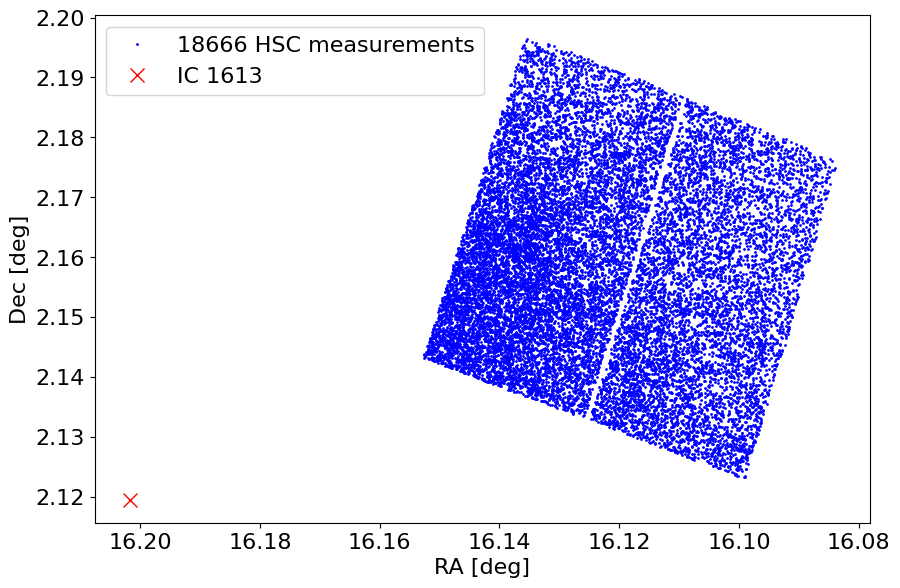

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot('MatchRA', 'MatchDec', 'bo', markersize=1, data=tab, label=f'{len(tab)} HSC measurements')
ax.plot(ra_ic1613, dec_ic1613, 'rx', label=target, markersize=10)
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]', aspect='equal')
ax.invert_xaxis()
_ = ax.legend(loc='best')

### Plot MAD variability index versus magnitude in F475W <a name="variability"></a>

The median absolute deviation is measured among the ~12 magnitude measurements in the catalog.  Some scatter is expected from noise (which increases for fainter objects).   Objects with MAD values that are high are likely to be variable.

Select variable objects that are not too faint.

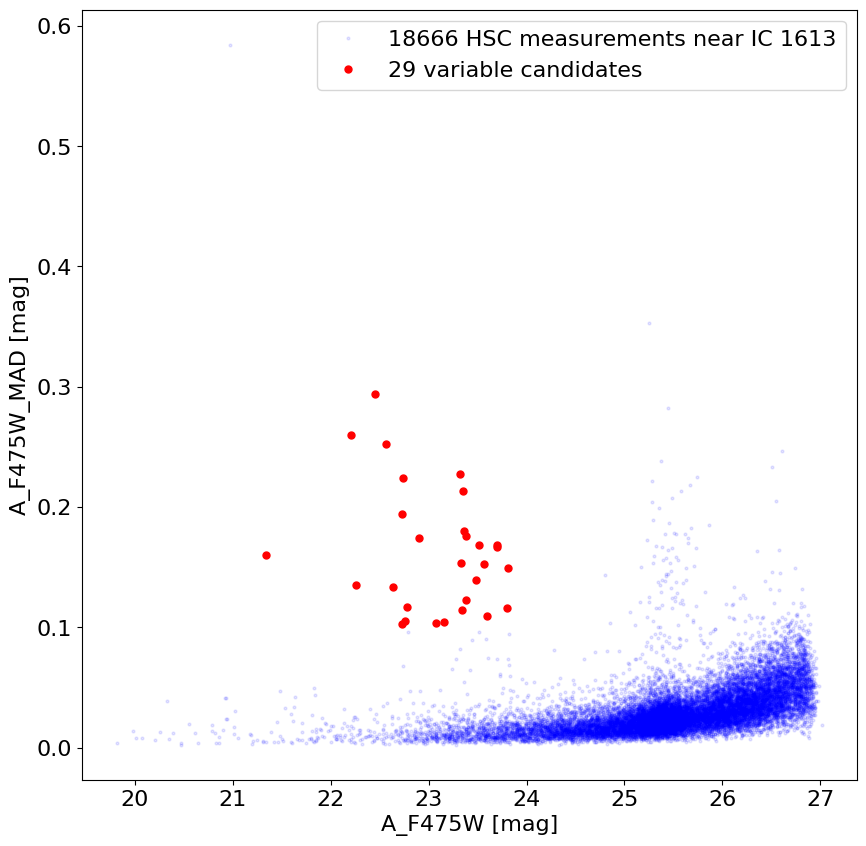

In [8]:
wvar = np.where((tab['A_F475W_MAD'] > 0.1) & (tab['A_F475W'] < 24) & (tab['A_F475W'] > 21))[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot('A_F475W', 'A_F475W_MAD', 'bo', markersize=2, alpha=0.1, data=tab,
        label=f'{len(tab)} HSC measurements near {target}')
ax.plot('A_F475W', 'A_F475W_MAD', 'ro', markersize=5, data=tab[wvar],
        label=f'{len(wvar)} variable candidates')
ax.set(xlabel='A_F475W [mag]', ylabel='A_F475W_MAD [mag]')
_ = ax.legend(loc='best')

### Check positions of variable objects in a color-magnitude diagram <a name="cmd"></a>

Note that these objects are generally located in the Cepheid instability strip.

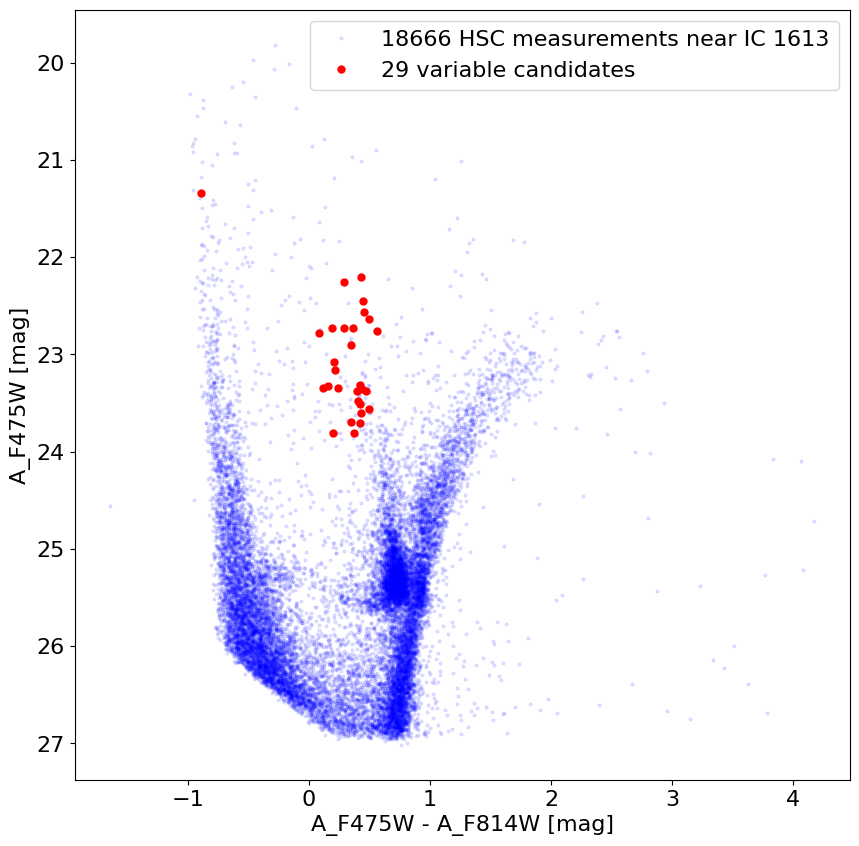

In [9]:
b_minus_i = tab['A_F475W'] - tab['A_F814W']

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(b_minus_i, tab['A_F475W'], 'bo', markersize=2, alpha=0.1,
        label=f'{len(tab)} HSC measurements near {target}')
ax.plot(b_minus_i[wvar], tab['A_F475W'][wvar], 'ro', markersize=5,
        label=f'{len(wvar)} variable candidates')
ax.set(xlabel='A_F475W - A_F814W [mag]', ylabel='A_F475W [mag]')
ax.invert_yaxis()
_ = ax.legend(loc='best')

### Query the API for the light curve for one of the objects <a name="lightcurve"></a>

Select the most variable object as an example. 

In [10]:
wvar = wvar[np.argsort(-tab['A_F475W_MAD'][wvar])]
iselect = wvar[0]
print(f"MatchID {tab['MatchID'][iselect]} B = {tab['A_F475W'][iselect]:.3f} B-I = {b_minus_i[iselect]:.3f}")
tab[wvar]

MatchID 80189155 B = 22.451 B-I = 0.450


MatchID,MatchRA,MatchDec,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,A_F475W,A_F475W_N,A_F475W_MAD,A_F814W,A_F814W_N,A_F814W_MAD
int64,float64,float64,int64,int64,int64,float64,float64,float64,int64,float64,float64,int64,float64
80189155,16.140740,2.155288,3,14,26,53965.29153,57009.86262,22.451,12,0.294,22.001,12,0.198
8200488,16.144772,2.152338,3,14,26,53965.29153,57009.86262,22.202,12,0.260,21.768,12,0.188
66012678,16.135134,2.154740,3,14,26,53965.29153,57009.86262,22.559,12,0.253,22.101,12,0.192
63078526,16.105513,2.155580,3,14,26,53965.29153,57009.86262,23.317,12,0.227,22.897,12,0.138
89909862,16.117180,2.168810,3,14,26,53965.29153,57009.86262,22.733,12,0.224,22.545,12,0.099
92119358,16.136563,2.182817,2,12,24,53965.29153,53967.71941,23.347,12,0.213,23.234,12,0.131
66980564,16.125611,2.135287,3,14,26,53965.29153,57009.86262,22.732,12,0.194,22.365,12,0.138
95722356,16.133030,2.175638,3,14,26,53965.29153,57009.86262,23.359,12,0.180,22.921,12,0.129
68356083,16.095709,2.147460,2,12,24,53965.29153,53967.71941,23.378,12,0.176,22.981,12,0.109


Get column metadata for detailed observation table (which has time-dependent magnitudes).

In [11]:
meta = hscmetadata("detailed")
print(len(meta), "columns in detailed")
pprint(meta['name'].tolist(), compact=True)

39 columns in detailed
['CatID', 'MatchID', 'MemID', 'SourceID', 'ImageID', 'Det', 'MatchRA',
 'MatchDec', 'SourceRA', 'SourceDec', 'D', 'DSigma', 'AbsCorr', 'XImage',
 'YImage', 'ImageName', 'Instrument', 'Mode', 'Detector', 'Aperture',
 'ExposureTime', 'StartTime', 'StopTime', 'StartMJD', 'StopMJD', 'WaveLength',
 'Filter', 'TargetName', 'FluxAper2', 'MagAper2', 'MagAuto', 'PropID', 'CI',
 'KronRadius', 'Flags', 'HTMID', 'X', 'Y', 'Z']


### Get separate light curves for F475W and F814W from the detailed table

In [12]:
columns = """MatchID,SourceID,StartMJD,Detector,Filter,MagAper2,Flags,ImageName""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

constraints = {'MatchID': tab['MatchID'][iselect], 'Detector': 'ACS/WFC'}
t0 = time.time()
f475 = hscsearch(table="detailed", release='v3', columns=columns, Filter='F475W', format="table", **constraints)
f814 = hscsearch(table="detailed", release='v3', columns=columns, Filter='F814W', format="table", **constraints)
print(f"{time.time()-t0:.1f} s: retrieved data and converted to {len(f475)} (F475W) and {len(f814)} (F814W) row astropy tables")

f475.sort('StartMJD')
f814.sort('StartMJD')
f475['MagAper2'].format = "{:.3f}"
f475['StartMJD'].format = "{:.5f}"
f814['MagAper2'].format = "{:.3f}"
f814['StartMJD'].format = "{:.5f}"

f475

1.0 s: retrieved data and converted to 12 (F475W) and 12 (F814W) row astropy tables


MatchID,SourceID,StartMJD,Detector,Filter,MagAper2,Flags,ImageName
int64,int64,float64,str7,str5,float64,int64,str26
80189155,4000999062305,53965.29153,ACS/WFC,F475W,22.192,0,hst_10505_07_acs_wfc_f475w
80189155,4000992888001,53965.42473,ACS/WFC,F475W,22.246,0,hst_10505_08_acs_wfc_f475w
80189155,4001095116962,53965.55794,ACS/WFC,F475W,22.376,0,hst_10505_09_acs_wfc_f475w
80189155,4000922680735,53965.69115,ACS/WFC,F475W,22.552,0,hst_10505_10_acs_wfc_f475w
80189155,4001042276145,53966.29057,ACS/WFC,F475W,22.705,0,hst_10505_11_acs_wfc_f475w
80189155,4001225221390,53966.42377,ACS/WFC,F475W,22.802,0,hst_10505_12_acs_wfc_f475w
80189155,4000895760719,53966.55698,ACS/WFC,F475W,22.779,0,hst_10505_13_acs_wfc_f475w
80189155,4000814317863,53966.69019,ACS/WFC,F475W,22.801,0,hst_10505_14_acs_wfc_f475w
80189155,4000830929643,53967.22301,ACS/WFC,F475W,22.526,0,hst_10505_15_acs_wfc_f475w


### Plot the light curves

The light curves appear well-behaved and are closely correlated in the two filters.

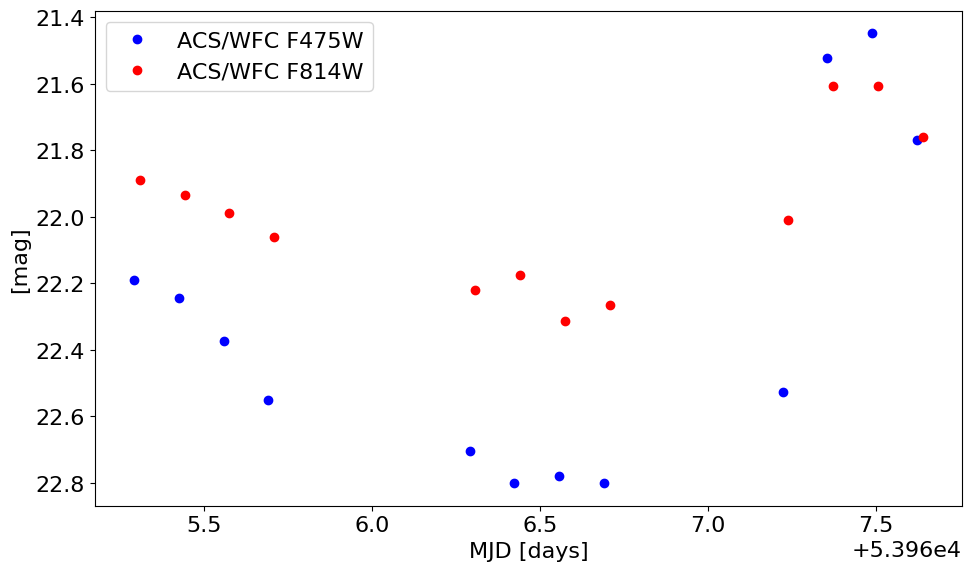

In [13]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

ax.plot('StartMJD', 'MagAper2', 'bo', data=f475, label='ACS/WFC F475W')
ax.plot('StartMJD', 'MagAper2', 'ro', data=f814, label='ACS/WFC F814W')

ax.set(xlabel='MJD [days]', ylabel='[mag]')
ax.invert_yaxis()
ax.legend()

### Extract HLA cutout images for the F475W images <a name="cutouts"></a>

Get HLA F475W cutout images for the example variable.  The `get_hla_cutout` function reads a single cutout image (as a JPEG grayscale image) and returns a PIL image object.  See the documentation on the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web service being used.

Examination of the images can be useful to identified cosmic-ray contamination and other possible image artifacts.  In this case, no issues are seen, so the light curve is likely to be reliable.

In [14]:
def get_hla_cutout(imagename, ra, dec, size=33, autoscale=99.5, asinh=1, zoom=1):
    
    """Get JPEG cutout for an image"""
    
    url = "https://hla.stsci.edu/cgi-bin/fitscut.cgi"
    r = requests.get(url, params=dict(ra=ra, dec=dec, size=size, format="jpeg",
                                      red=imagename, autoscale=autoscale, asinh=asinh, zoom=zoom))
    im = Image.open(BytesIO(r.content))
    return im

In [15]:
# sort images by magnitude from faintest to brightest
isort = np.argsort(-f475['MagAper2'])

imagename = f475['ImageName'][isort]
mag = f475['MagAper2'][isort]
mjd = f475['StartMJD'][isort]

nim = len(imagename)
ncols = 4 # images per row
nrows = (nim+ncols-1)//ncols

imsize = 15
mra = tab['MatchRA'][iselect]
mdec = tab['MatchDec'][iselect]

In [16]:
# download list of images; might take a minute
images = [get_hla_cutout(imagename[k], mra, mdec, size=imsize) for k in range(nim)]

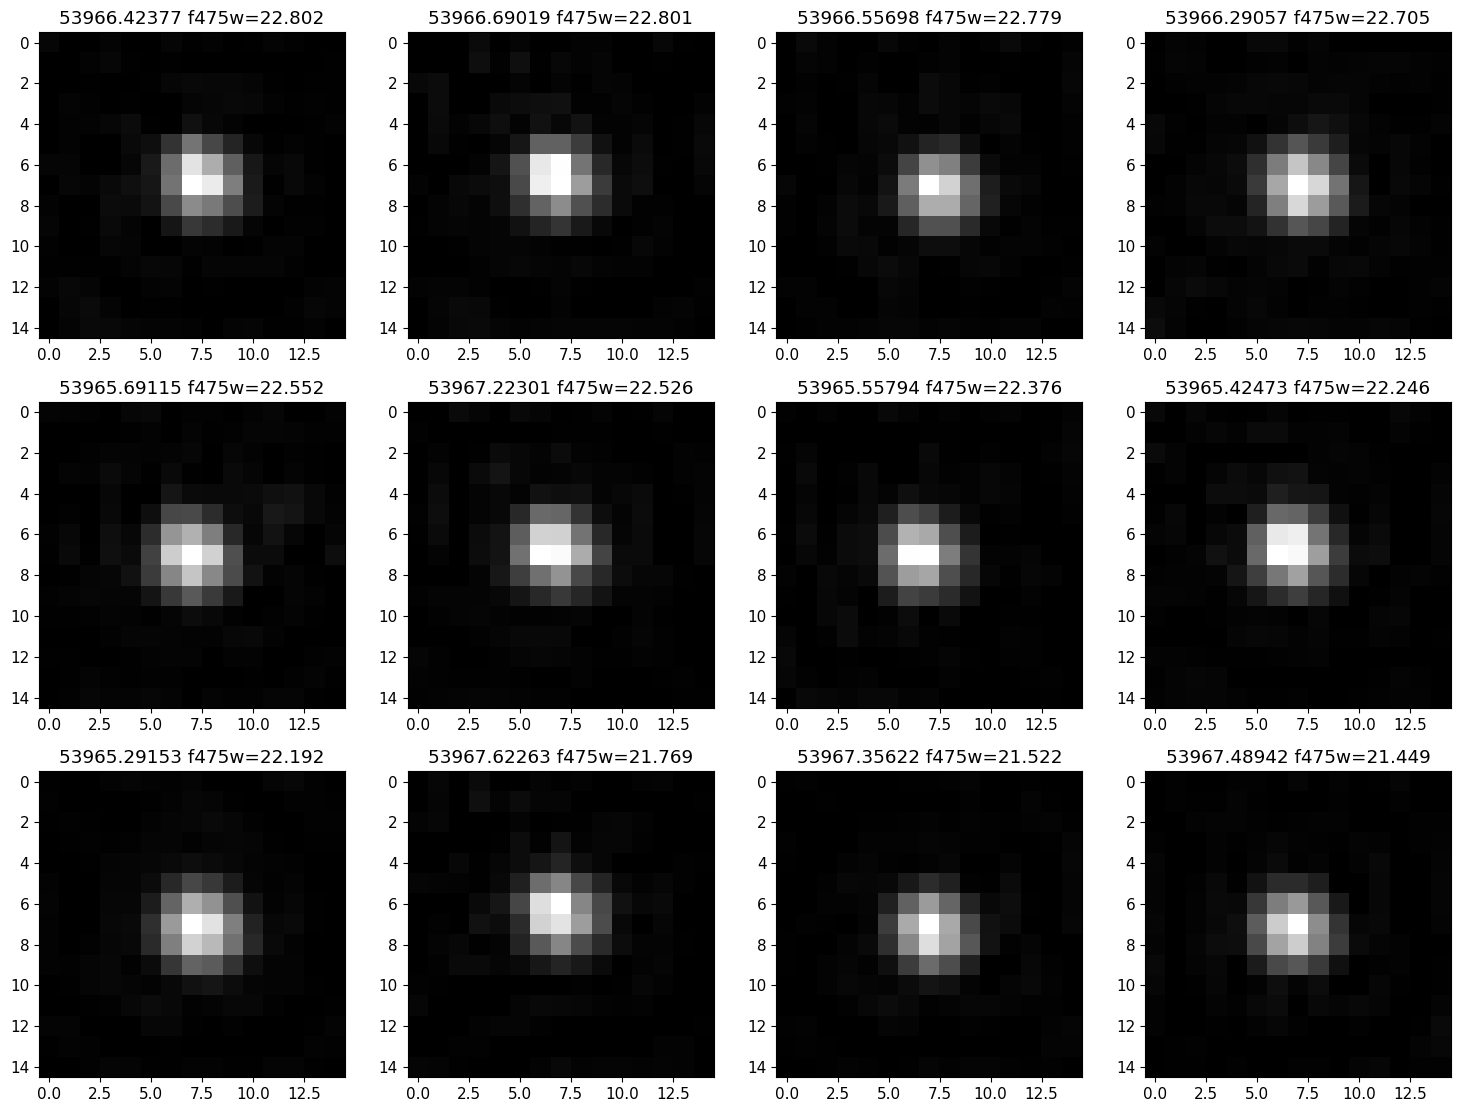

In [17]:
plt.rcParams.update({"font.size": 11})
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, (15/ncols)*nrows), tight_layout=True)

axes = axes.flat

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, origin="upper", cmap="gray")
    ax.set_title(f'{mjd[i]:.5f} f475w={mag[i]:.3f}')

## About this Notebook

**Authors**: Rick White, Trenton McKinney <br>
**Keywords**: HSC, catalogs <br>
**Last Updated**: October 2024 <br>

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>